# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
#!pip3 install torch
#!pip3 install torchvision
#!pip install d2l

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
from torch import nn
import torch
import os
from tqdm.notebook import tqdm

from d2l import torch as d2l

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.1


# Preparing Training and Test Sets

In [3]:
class_names = ['normal', 'viral', 'covid']
root_dir    = 'COVID-19_Radiography_Dataset'


# test set proportion
test_set_proportion = 0.3


os.mkdir(os.path.join(root_dir, 'test')) # # create empty test set folder

for c in class_names: # create subfolders in the test set folder     
    if not os.path.isdir(os.path.join(root_dir, 'test', c)):
        os.mkdir(os.path.join(root_dir, 'test', c))

for c in class_names:
    images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
    selected_images = random.sample(images, int(np.ceil(test_set_proportion*len(images))))
    for image in selected_images:
        source_path = os.path.join(root_dir, c, image)
        target_path = os.path.join(root_dir, 'test', c, image)
        shutil.move(source_path, target_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'COVID-19_Radiography_Dataset\\test'

# Creating Custom Dataset

In [3]:
class Test(object):
      
    # This function prints the type
    # of the object passed as well 
    # as the object item
    def __getitem__(self, items):
        print (type(items), items)

# Driver code
test = Test()

test[5]
test[5:65:5]
test['GeeksforGeeks']
test[1, 'x', 10.0]
test['a':'z':2]
test[object()]

<class 'int'> 5
<class 'slice'> slice(5, 65, 5)
<class 'str'> GeeksforGeeks
<class 'tuple'> (1, 'x', 10.0)
<class 'slice'> slice('a', 'z', 2)
<class 'object'> <object object at 0x00000216020E2E50>


In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): #check if the file is actually png file
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
    
    # Need a __len__(self) function for torch.utils.data.DataLoader
    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    # Need a __getitem__ function for next(iter(dataset)) within torch.utils.data.DataLoader for training and testing.
    #        This function needs to return/provide (image) data (in numpy matrix format) and label.
    #        Then DataLoader will warp them to be DataLoader type which can be transformed to tensor.
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names) # need to investigate why we can do the random sampling
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)
        

# Image Transformations

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [6]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [7]:
train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral': 'COVID-19_Radiography_Dataset/viral',
    'covid': 'COVID-19_Radiography_Dataset/covid'
}

In [8]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 4994 normal examples
Found 659 viral examples
Found 1772 covid examples


In [9]:
test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral': 'COVID-19_Radiography_Dataset/test/viral',
    'covid': 'COVID-19_Radiography_Dataset/test/covid'
}

In [10]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 2141 normal examples
Found 283 viral examples
Found 760 covid examples


In [11]:
batch_size = 64

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 117
Number of test batches 50


# Data Visualization

In [12]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        # print(i)
        plt.subplot(1, len(images), i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

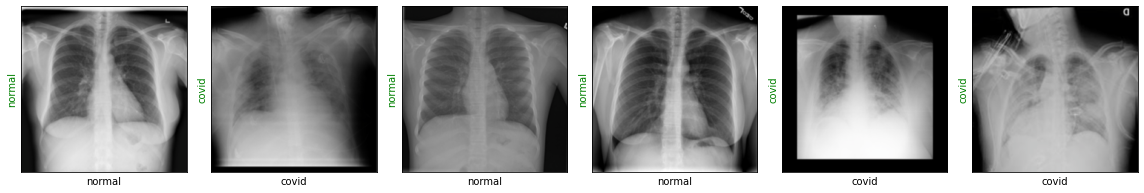

In [13]:
images, labels = next(iter(dl_train))
show_images(images[:6], labels, labels)

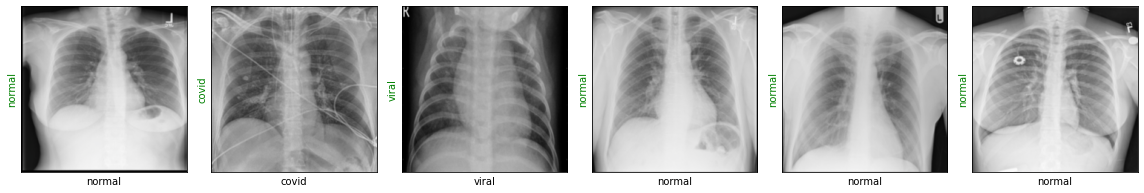

In [14]:
images, labels = next(iter(dl_test))
show_images(images[:6], labels, labels)

# Creating the Model

In [15]:
resnet18 = torchvision.models.resnet18(pretrained = True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3) 
loss_fn     = torch.nn.CrossEntropyLoss(reduction='mean') # inputs will be 1) predicted prob. of size batch_size*num_class and 2) true class labels
optimizer   = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [17]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    
    resnet18.cpu()
    outputs  = resnet18(images)
    _, preds = torch.max(outputs, 1)
    print(f"The prediction accuracy for the first batch in validation set: {sum(preds == labels)/len(preds)}")
    show_images(images[:6], labels, preds)

The prediction accuracy for the first batch in validation set: 0.390625


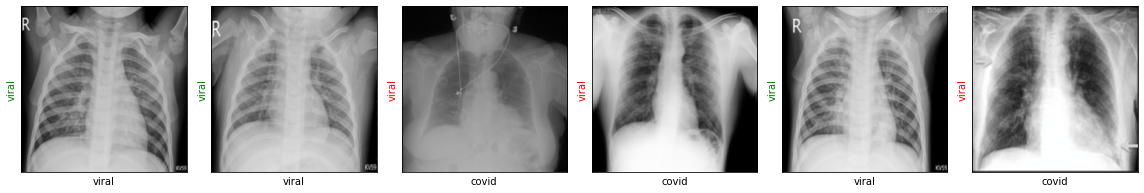

In [18]:
show_preds()

# Training the Model

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [20]:
# This is for evaluating the model performance on validation set
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for i, (X, y) in enumerate(data_iter):
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [22]:
def train(num_epochs, init_weights=True):
    
    if init_weights==True:
        def init_weights(m):
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                nn.init.xavier_uniform_(m.weight)
        resnet18.apply(init_weights)

    
    print('Starting training..')
    
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])
    
    
    for epoch in range(num_epochs):        
        
        #send model to device we are using
        resnet18.to(device)
        
        timer, num_batches = d2l.Timer(), len(dl_train)
        
        
        #progress_bar = tqdm(dl_train, desc = 'Epoch {:1d}'.format(epoch),
        #                leave = False,   #overwrite after each epoch
        #                disable = False) # this returns a python list
       
        # after each batch, will check score on validation set.
        accuracy_validation = evaluate_accuracy_gpu(net=resnet18, data_iter=dl_test)
        animator.add(epoch, (None, None, accuracy_validation))
        
        
        resnet18.train() # set model to training phase
        
        train_loss = 0.
        
        # i is the batch_index
        for i, (X, y) in enumerate(dl_train):
            
            # print(type(batch), "type of batch before") # python list
            # print(len(batch)) # is 2, each element is a torch.tensor
            # print(batch) # a python list on CPU, the first element is a big tensor of size batch*channel*height*width
            
            # batch = tuple(b.to(device) for b in batch) # move the data from CPU to GPU and assign a pointer called batch
        
            # print(type(batch), "type of batch") # tuple of length 2, each element is a torch.tensor
            # print(len(batch)) is 2
            # print(batch) a tensor on the GPU, the first element is a big tensor of size batch*channel*height*width
                 
                
            X, y = X.to(device), y.to(device)
                
            images_train = X # batch[0]
            labels_train = y # batch[1]
            
            timer.start()
            
            optimizer.zero_grad()
            outputs_train = resnet18(images_train)
            loss_train = loss_fn(outputs_train, labels_train) # default is average loss, here we use default.
            loss_train.backward()
            optimizer.step()
            
            
            _, preds_train = torch.max(outputs_train, 1)
            
            accuracy_train = sum(preds_train == labels_train)/len(labels_train)
            
            #print("let's check what's the accuracy is and pay attention to it's location", accuracy_train) it's on cuda
            
            timer.stop()
            
            
            # draw plot, trianing loss and accurary are drawn densely
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + ((i + 1) / num_batches), (loss_train, accuracy_train, None)) 
            
            
        

    print(f'loss {loss_train:.3f}, train acc {accuracy_train:.3f}, '
          f'test acc {accuracy_validation:.3f}')
    print(f'{len(labels_train) * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')        
            
    #progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
            

In [23]:
   
        """    
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')
    """

"    \nfor train_step, (images, labels) in enumerate(dl_train):\n    optimizer.zero_grad()\n    outputs = resnet18(images)\n    loss = loss_fn(outputs, labels)\n    loss.backward()\n    optimizer.step()\n    train_loss += loss.item()\n    if train_step % 20 == 0:\n        print('Evaluating at step', train_step)\n\n        accuracy = 0\n\n        resnet18.eval() # set model to eval phase\n\n        for val_step, (images, labels) in enumerate(dl_test):\n            outputs = resnet18(images)\n            loss = loss_fn(outputs, labels)\n            val_loss += loss.item()\n\n            _, preds = torch.max(outputs, 1)\n            accuracy += sum((preds == labels).numpy())\n\n        val_loss /= (val_step + 1)\n        accuracy = accuracy/len(test_dataset)\n        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')\n\n        show_preds()\n\n        resnet18.train()\n\n        if accuracy >= 0.95:\n            print('Performance condition satisfied, stopping..')\n      

# Final Results

loss 1.105, train acc 0.000, test acc 0.914
2.6 examples/sec on cuda
Wall time: 9min 16s


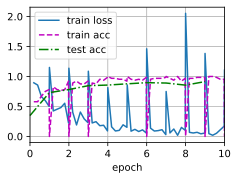

In [24]:
%%time

train(num_epochs=10)

The prediction accuracy for the first batch in validation set: 0.90625


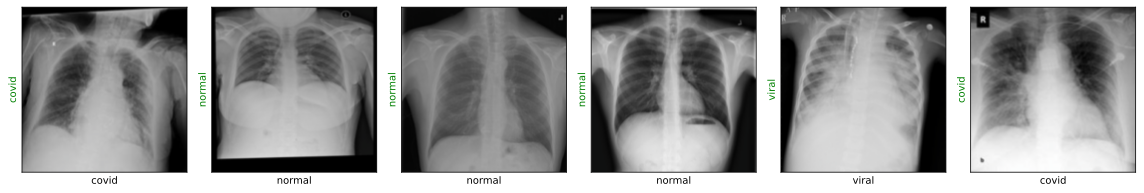

In [25]:
show_preds()